# Mario fMRI Tutorial
## Complete Analysis Pipeline: From GLM to Brain Encoding

<br>

### Overview of the CNeuromod Mario Dataset

**What we'll cover:**
- Dataset exploration and behavioral annotations
- GLM analysis: Actions and game events
- RL agent: Learning representations from gameplay
- Brain encoding: Predicting fMRI from learned features

<br>

---

*CNeuromod 2025*

In [1]:
# Setup - hidden from presentation
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import plotting
import warnings
warnings.filterwarnings('ignore')

# Add src to path
src_dir = Path('..') / 'src'
sys.path.insert(0, str(src_dir))

from utils import (
    get_sourcedata_path,
    load_events,
    get_session_runs
)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Define constants
SUBJECT = 'sub-01'
SESSION = 'ses-010'
TR = 1.49

print("Setup complete!")

Setup complete!


# Introduction

## The CNeuromod Mario Dataset

## The CNeuromod Mario Dataset

### A Naturalistic fMRI Paradigm

**Participants:** 5 subjects playing Super Mario Bros (NES) in the scanner

**Task:** Natural gameplay - no constraints on strategy or behavior

**Experimental Regimen:**
- **Discovery Phase:** Levels played sequentially to learn game mechanics and layouts
- **Practice Phase:** Levels sampled randomly to test generalization and skill transfer

**Levels Played:** 22 levels across 8 worlds
- **World 1:** w1l1, w1l2, w1l3 (grassland - easy)
- **World 2:** w2l1, w2l3 (grassland - medium)
- **World 3:** w3l1, w3l2, w3l3 (forest - medium)
- **World 4:** w4l1, w4l2, w4l3 (forest - hard)
- **World 5:** w5l1, w5l2, w5l3 (sky - hard)
- **World 6:** w6l1, w6l2, w6l3 (winter - medium)
- **World 7:** w7l1, w7l3 (fortress - very hard)
- **World 8:** w8l1, w8l2, w8l3 (castle - very hard)

*Selection: All non-underwater and non-Bowser levels for consistent gameplay mechanics*

**Acquisition:**
- TR = 1.49s (multiband fMRI)
- Run duration: variable (~10 min)
- 3-5 runs per session. 
- Total playtime: ~84 hours across all subjects

**Key insight:** Real-world complexity with rich behavioral structure

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px; margin-top: 20px;">
<b>Why naturalistic paradigms?</b><br>
Traditional fMRI uses simple, repetitive tasks. Naturalistic paradigms like gameplay capture complex, dynamic behavior closer to real-world cognition.
</div>

## Analysis Pipeline Overview

### Two Complementary Approaches

```
┌─────────────────────────────────────────────────────────────────┐
│                         fMRI Data                               │
│                    (BOLD time series)                           │
└────────────┬────────────────────────────┬───────────────────────┘
             │                            │
    ┌────────▼─────────┐         ┌────────▼──────────┐
    │   GLM Analysis   │         │   RL Agent        │
    └────────┬─────────┘         └────────┬──────────┘
             │                            │
    ┌────────▼─────────┐         ┌────────▼──────────┐
    │ Hypothesis-driven│         │ Learned features  │
    │ contrasts        │         │ (CNN activations) │
    │ - LEFT vs RIGHT  │         └────────┬──────────┘
    └────────┬─────────┘                  │
             │                   ┌────────▼──────────┐
             │                   │ Ridge Encoding    │
             │                   │ (Predict BOLD)    │
             │                   └────────┬──────────┘
             │                            │
    ┌────────▼────────────────────────────▼──────────┐
    │         Brain Activity Maps                    │
    │    Which regions? What representations?        │
    └────────────────────────────────────────────────┘
```

**GLM:** Hand-crafted regressors → Interpretable contrasts

**Encoding:** Learned representations → Predictive power

## BIDS Data Organization

### Where to Find What You Need

The Mario dataset follows the **Brain Imaging Data Structure (BIDS)** standard:

```
sourcedata/
├── mario/                           # Raw BIDS dataset
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── func/
│               ├── *_events.tsv     # Basic event timing
│               └── *_bold.nii.gz    # Raw functional scans
│
├── mario.fmriprep/                  # Preprocessed BOLD data
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── func/
│               ├── *_desc-preproc_bold.nii.gz      # Preprocessed BOLD
│               ├── *_desc-brain_mask.nii.gz        # Brain mask
│               └── *_desc-confounds_timeseries.tsv # Motion/physio confounds
│
├── mario.annotations/               # Rich behavioral annotations
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── func/
│               └── *_desc-annotated_events.tsv     # Actions + game events
│
├── mario.replays/                   # Frame-by-frame gameplay data
│   └── sub-{01,02,03,05,06}/
│       └── ses-{001..030}/
│           └── beh/
│               ├── infos/*.json     # Metadata: duration, cleared, phase
│               ├── confs/*.npy      # Low-level features (luminance, etc.)
│               └── *.bk2            # BizHawk replay files (60fps)
│
└── cneuromod.processed/             # Anatomical templates
    └── smriprep/
        └── sub-{01,02,03,05,06}/
            └── anat/
                └── *_MNI152NLin2009cAsym_preproc.nii.gz  # T1w in MNI space
```

**Key Files for Analysis:**

| Data Type | Location | Use Case |
|-----------|----------|----------|
| **Preprocessed BOLD** | `mario.fmriprep/*/*/func/*_desc-preproc_bold.nii.gz` | GLM, encoding models |
| **Brain mask** | `mario.fmriprep/*/*/func/*_desc-brain_mask.nii.gz` | Restrict analysis to brain |
| **Confounds** | `mario.fmriprep/*/*/func/*_desc-confounds_timeseries.tsv` | Motion/physiology regressors |
| **Action events** | `mario.annotations/*/*/func/*_desc-annotated_events.tsv` | Button presses, game events |
| **Replay metadata** | `mario.replays/*/*/beh/infos/*.json` | Success/failure, duration, phase |
| **Low-level features** | `mario.replays/*/*/beh/confs/*.npy` | Luminance, optical flow, audio |
| **Anatomical** | `cneuromod.processed/smriprep/*/anat/*_MNI*.nii.gz` | Registration, visualization |

## Dataset Statistics

### Global Overview Across All Subjects

Let's look at the complete dataset statistics computed from all replay metadata:

In [ ]:
# Load and display dataset statistics
from utils import compute_dataset_statistics

print("Loading dataset statistics...\n")
stats = compute_dataset_statistics()

# Display per-subject statistics
print("=" * 80)
print("PER-SUBJECT STATISTICS")
print("=" * 80)
print(stats['per_subject'].to_string(index=False))

# Display total statistics
print("\n" + "=" * 80)
print("DATASET-WIDE STATISTICS")
print("=" * 80)
for key, value in stats['total_stats'].items():
    print(f"  {key:.<45} {value}")

# Display phase breakdown
print("\n" + "=" * 80)
print("EXPERIMENTAL DESIGN")
print("=" * 80)
discovery_pct = 100 * stats['total_stats']['Discovery Phase Reps'] / stats['total_stats']['Total Repetitions']
practice_pct = 100 * stats['total_stats']['Practice Phase Reps'] / stats['total_stats']['Total Repetitions']
print(f"  Discovery Phase: {stats['total_stats']['Discovery Phase Reps']:>5} reps ({discovery_pct:.1f}%)")
print(f"  Practice Phase:  {stats['total_stats']['Practice Phase Reps']:>5} reps ({practice_pct:.1f}%)")

# Display levels
print("\n" + "=" * 80)
print("LEVELS PLAYED (22 total)")
print("=" * 80)
for world, levels in sorted(stats['levels_by_world'].items()):
    levels_str = ", ".join(levels)
    print(f"  World {world}: {levels_str}")

print("\n✓ Dataset statistics loaded successfully!")

Loading dataset statistics...

PER-SUBJECT STATISTICS
Subject  Total Repetitions  Successful Completions  Failures  Success Rate (%)  Total Duration (min)  Sessions
 sub-01                797                     576       221              72.3                 821.6        21
 sub-02                714                     418       296              58.5                1048.0        23
 sub-03                627                     391       236              62.4                1007.0        29
 sub-05                634                     331       303              52.2                1077.8        22
 sub-06                602                     485       117              80.6                1083.4        25

DATASET-WIDE STATISTICS
  Total Repetitions............................ 3374
  Total Successful Completions................. 2201
  Total Failures............................... 1173
  Overall Success Rate (%)..................... 65.2
  Total Playtime (hours)...................

# Dataset Exploration

## Rich Behavioral Annotations

## Behavioral Annotations

The `mario.annotations` dataset provides three types of events:

**1. Action events (button presses):**
- A, B, LEFT, RIGHT, UP, DOWN
- Precise onset and duration
- **Button mappings:**
  - **A = JUMP** (short taps, mean duration ~0.3s)
  - **B = RUN/FIREBALL** (held continuously, mean duration ~12s)
  - LEFT/RIGHT = Movement
  - UP = Enter pipe, DOWN = Crouch

**2. Game events:**
- Kill/stomp, Kill/kick (defeating enemies)
- Hit/life_lost (player damage)
- Powerup_collected, Coin_collected (rewards)
- Flag_reached (level completion)

**3. Scene information:**
- Level segmentation
- Unique scene codes for each game section

Let's load and visualize these events!

In [3]:
# Load events for all runs in the session

sourcedata_path = get_sourcedata_path()

try:
    runs = get_session_runs(SUBJECT, SESSION, sourcedata_path)
    print(f"Found {len(runs)} runs: {runs}\n")
    
    # Load all events
    all_events = []
    for run in runs:
        events = load_events(SUBJECT, SESSION, run, sourcedata_path)
        all_events.append(events)
        print(f"{run}: {len(events)} events")
    
    session_events = pd.concat(all_events, ignore_index=True)
    print(f"\nTotal events: {len(session_events)}")
    
    # Categorize
    button_events = ['A', 'B', 'LEFT', 'RIGHT', 'UP', 'DOWN']
    game_events = ['Kill/stomp', 'Kill/kick', 'Hit/life_lost', 
                   'Powerup_collected', 'Coin_collected']
    
    n_buttons = len(session_events[session_events['trial_type'].isin(button_events)])
    n_game = len(session_events[session_events['trial_type'].isin(game_events)])
    
    print(f"\nButton presses: {n_buttons}")
    print(f"Game events: {n_game}")
    
    # Top events
    print("\nTop 10 most frequent events:")
    print(session_events['trial_type'].value_counts().head(10))
    
    EVENTS_LOADED = True
    
except Exception as e:
    print(f"Error loading events: {e}")
    print("Using demo data...")
    EVENTS_LOADED = False

Found 4 runs: ['run-1', 'run-2', 'run-3', 'run-4']

run-1: 953 events
run-2: 986 events
run-3: 892 events
run-4: 1033 events

Total events: 3864

Button presses: 3363
Game events: 404

Top 10 most frequent events:
trial_type
A                 1515
RIGHT              953
LEFT               711
Coin_collected     275
B                  152
Hit/life_lost       58
Kill/stomp          47
gym-retro_game      36
Kill/impact         32
Brick_smashed       28
Name: count, dtype: int64


Import necessary libraries and configure the environment.

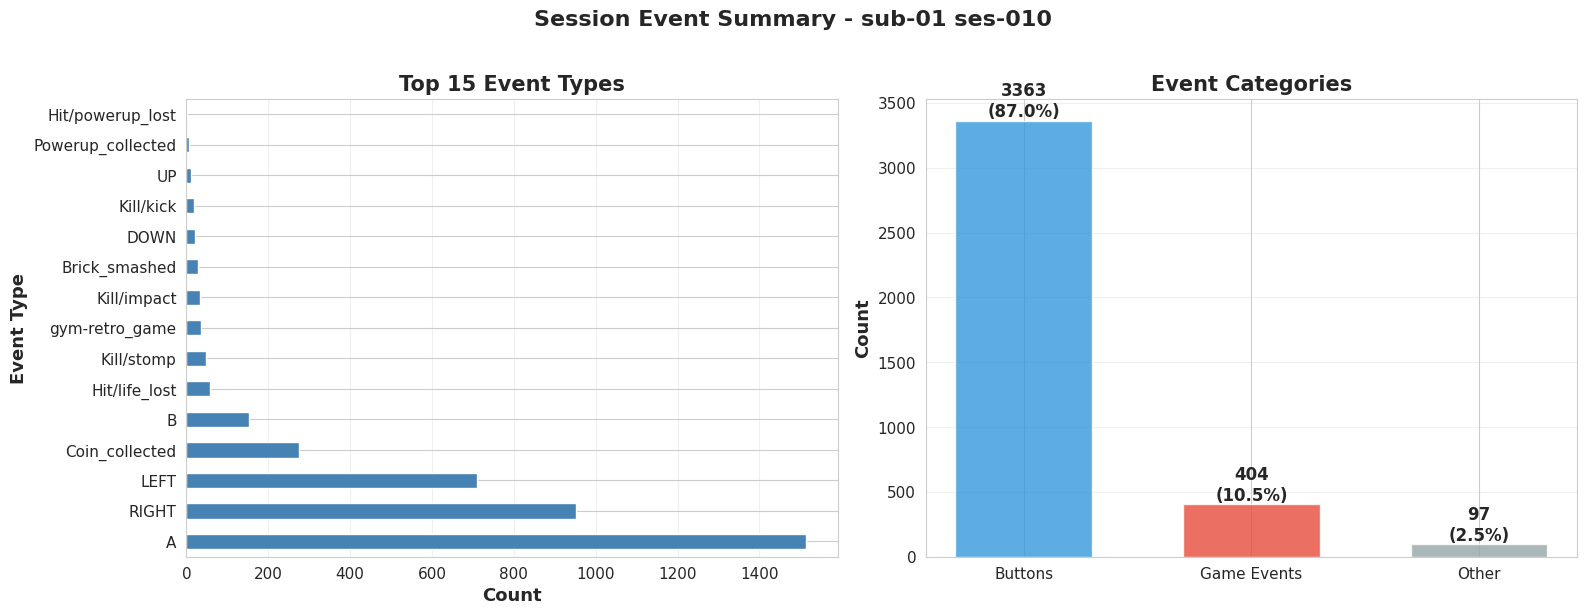

In [4]:
# Visualize event frequencies

from glm_utils import plot_event_frequencies

fig = plot_event_frequencies(
    session_events, n_buttons, n_game,
    SUBJECT, SESSION
)
plt.show()

## Timeline Visualization

**Goal:** Understand the temporal structure of gameplay

We'll visualize:
- Button press patterns over time
- Game event occurrences
- Event density (actions per second)

**What to look for:**
- Clusters of activity (intense gameplay moments)
- Gaps (deaths, level transitions)
- Relationships between buttons and game events

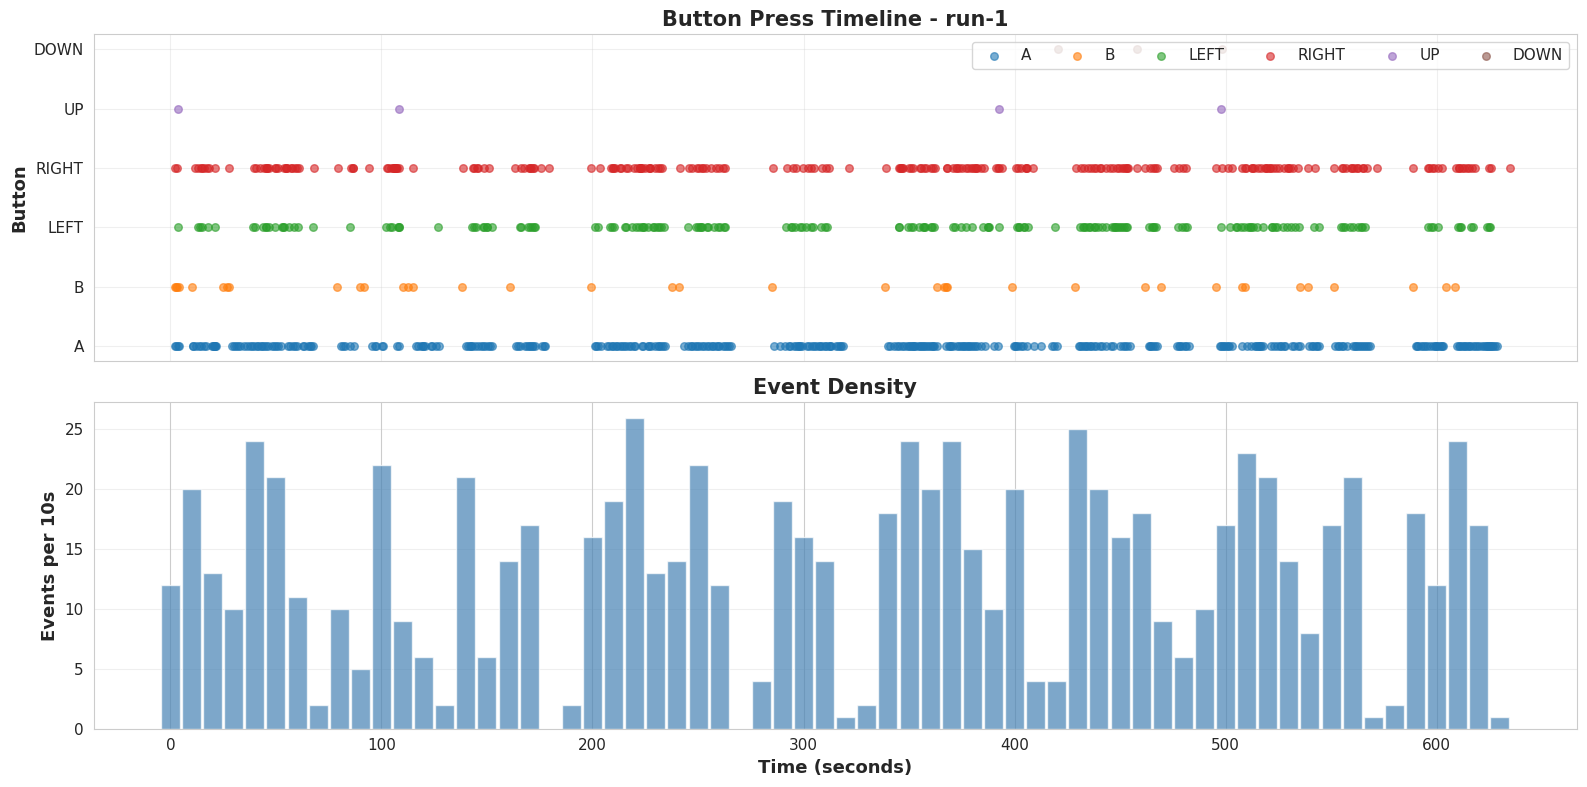

In [5]:
# Event timeline for first run

from glm_utils import plot_event_timeline

if EVENTS_LOADED and len(all_events) > 0:
    fig = plot_event_timeline(all_events[0], runs[0], button_events)
    plt.show()
else:
    print("Timeline not available.")

## Game Replay Data

### Frame-by-frame recordings (.bk2 files)

**What's in a replay?**
- 60 Hz game frames
- Button states for each frame
- RAM variables: player position, score, lives, time, power-up state

**Uses:**
1. **RL training:** Extract frames as visual input for CNN
2. **Validation:** Verify behavioral annotations
3. **Visualization:** Show actual gameplay moments

**For this tutorial:** We'll use simplified proxy features instead of full frame extraction (faster for demonstration)

<div style="background-color: #fff3cd; padding: 10px; border-radius: 5px; margin-top: 20px;">
<b>Note:</b> Full replay processing requires BizHawk emulator and can extract ~18,000 frames per run. For efficiency, we use pre-computed features.
</div>